## Setup

___

#### Install dependencies

# %%bash

!pip install numpy pandas matplotlib torch torchvision scikit-learn seaborn

!pip install opencv-python

#### Import dependencies

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image

import os
import cv2

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import KFold

from image_dataloader import SocialSignalDataset


#### Initialize constants

In [4]:
# dataset
dataset_path = 'data/train'

image_length = 112
image_size = (image_length, image_length)

label_mapping = {
    0: "surprise",
    1: "fear"
}

# loaders
batch_size = 16

# model training
num_epochs =  5


## Dataset

---

#### Load and transform the dataset

In [5]:
img_transform = transforms.Compose([
    transforms.Grayscale(3), # RGB
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

dataset = SocialSignalDataset(root_dir=dataset_path, transform=img_transform)

#### Split data set into training and validation

In [6]:
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [0.8, 0.2])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) 
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True) 

# Check input size for forward feed network
for inputs, labels in train_loader:
    print("Input shape:", inputs.shape)
    print("Labels shape:", labels.shape)
    break  # We only want to check the first batch

Input shape: torch.Size([16, 3, 112, 112])
Labels shape: torch.Size([16])


## Model Setup
___

#### CNN

In [7]:
class SocialSignalModel(nn.Module):
    def __init__(self, num_classes=2):
        super(SocialSignalModel, self).__init__()
        """"
        input_channel: 3 or 4 // test which one gets better inputs
            - 3: for RGB
            - 4: +1 for Depth from camera
        num_classes: 2 
            0 for surprise, 1 for fear
        """
        
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        ) 
        
        # Input size 128 * 14 * 14
        self.in_features = 128 * 14 * 14 #Flattened size after 3 Conv2d Layers and Pooling
        self.fc = nn.Linear(self.in_features, num_classes) # in_features = batch_size

    def forward(self, x):
        # TODO: IMPLEMENT
        # CNN --> Conv2d(N,Cin,H,W) --> (N, C_out, H_out,W_out)
        x = self.cnn(x)

        # Flatten 
        x = x.view(-1,self.in_features)

        # Fully Connected Layer
        x = self.fc(x)
        
        return x

#### Training

In [8]:
# Training function to use for model training and 7-fold cross validation 
def training(train_loader, num_epochs, model, device, criterion, optimizer):
    # From Assignment 3 Training
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0
        correct = 0
        total = 0

        # Loop over each batch
        for i, (sequences, labels) in enumerate(train_loader):
            sequences, labels = sequences.to(device), labels.to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(sequences)

            # Compute loss
            loss = criterion(outputs, labels)

            # Backward pass
            loss.backward()

            # Optimize the model
            optimizer.step()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            running_loss += loss.item()

        # Print statistics for the epoch
        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = 100 * correct / total
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")
    return model
        # if epoch%5 == 0: # change the saving frequency as you want
        #     model_path = os.path.join('./model_configs', f'image_lstm_model_{epoch}.pth')
        #     torch.save(model.state_dict(), model_path)

In [9]:
# Set device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the model
model = SocialSignalModel().to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()  # For multi-class classification
optimizer = optim.Adam(model.parameters(), lr=0.001) 

model = training(train_loader, num_epochs, model, device, criterion, optimizer)

Epoch [1/5], Loss: 0.6928, Accuracy: 50.00%
Epoch [2/5], Loss: 0.6806, Accuracy: 59.64%
Epoch [3/5], Loss: 0.6563, Accuracy: 60.84%
Epoch [4/5], Loss: 0.6424, Accuracy: 60.84%
Epoch [5/5], Loss: 0.6139, Accuracy: 59.64%


#### Get outputs for train and validation datasets

In [10]:
model.eval()

val_predictions = []
val_labels = []

with torch.no_grad():  # No gradients needed for inference
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        outputs = model(inputs)
        _, predictions = torch.max(outputs, 1)

        val_predictions.extend(predictions.cpu().numpy())
        val_labels.extend(labels.cpu().numpy())

train_predictions = []
train_labels = []

with torch.no_grad():  # No gradients needed for inference
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        outputs = model(inputs)
        _, predictions = torch.max(outputs, 1)

        train_predictions.extend(predictions.cpu().numpy())
        train_labels.extend(labels.cpu().numpy())

#### Model summary

In [11]:
train_accuracy = accuracy_score(train_labels, train_predictions)
val_accuracy = accuracy_score(val_labels, val_predictions)

precision = precision_score(val_labels, val_predictions, average='weighted')
recall = recall_score(val_labels, val_predictions, average='weighted')
f1 = f1_score(val_labels, val_predictions, average='weighted')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Train Accuracy: {train_accuracy * 100:.2f}%")
print(f"Test Accuracy: {val_accuracy * 100:.2f}%")
print(f"F1 Score: {f1:.4f}")

Precision: 0.6099
Recall: 0.6098
Train Accuracy: 69.88%
Test Accuracy: 60.98%
F1 Score: 0.6084


#### Confusion matrix on validation dataset

[[14  7]
 [ 9 11]]


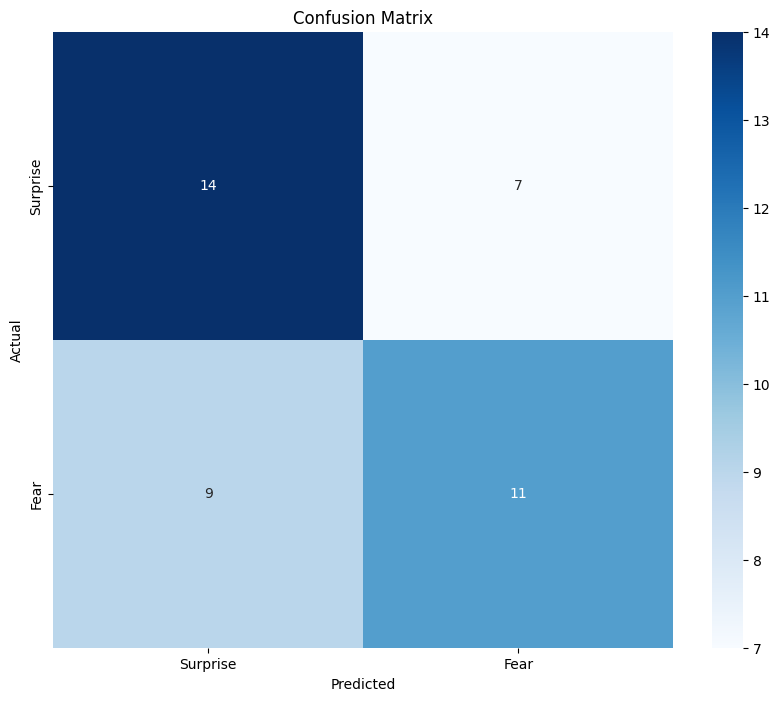

In [12]:
# ref: https://www.w3schools.com/python/python_ml_confusion_matrix.asp

cm = confusion_matrix(val_labels, val_predictions)

print(cm)

ticks = ["Surprise", "Fear"]

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=ticks, yticklabels=ticks)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## Evaluation

___

#### ROC-AUC

FPR: [0.         0.33333333 1.        ], Len: 3
TPR: [0.   0.55 1.  ], Len: 3
AUC: 0.6083333333333334


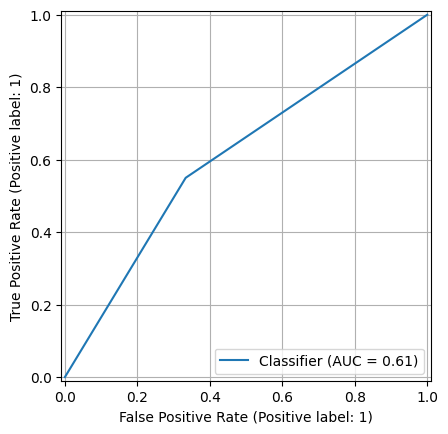

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import RocCurveDisplay

fpr, tpr, thresholds = roc_curve(val_labels, val_predictions)
auc_score = roc_auc_score(val_labels, val_predictions)

print(f'FPR: {fpr}, Len: {len(fpr)}')
print(f'TPR: {tpr}, Len: {len(tpr)}')
print(f'AUC: {auc_score}')

roc_display2 = RocCurveDisplay.from_predictions(val_labels, val_predictions)
plt.grid(True)
plt.show()



#### 7-Fold Cross Validation

In [ ]:
f1_scores = []
n_splits = 7
kf = KFold(n_splits=n_splits, shuffle=False)

for fold, (train_id,test_id) in enumerate(kf.split(train_dataset)):
    print(f'Current Fold: {fold}')

    fold_subset = torch.utils.data.Subset(train_dataset, train_id)
    fold_loader = DataLoader(fold_subset, batch_size=16, shuffle=True, num_workers=4 )

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = SocialSignalModel().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001) 
    model = training(fold_loader, num_epochs=num_epochs, model=model, device=device, criterion=criterion, optimizer=optimizer)
    model.eval()
    
    predictions = []
    labels = []
    with torch.no_grad():  # No gradients needed for inference
        for x,y in val_loader:
            x = x.to(device) # Sequences
            y = y.to(device) # Labels
            y_predicted = model(x)
            _, predicted = torch.max(y_predicted, 1)
            labels.extend(y.cpu().numpy())
            predictions.extend(predicted.cpu().numpy())
                
    predictions = np.array(predictions)
    labels = np.array(labels)
    f1 = f1_score(labels,predictions, average='weighted')
    print(f'FOLD{fold} f1score: {f1}')
    f1_scores.append(f1)

f1_mean = np.mean(f1_scores)
print(f'Average f1 score: {f1_mean:.2f}')

Current Fold: 0
Epoch [1/5], Loss: 0.7221, Accuracy: 53.52%
Epoch [2/5], Loss: 0.6890, Accuracy: 53.52%
Epoch [3/5], Loss: 0.6540, Accuracy: 65.49%
Epoch [4/5], Loss: 0.6208, Accuracy: 64.79%
Epoch [5/5], Loss: 0.5451, Accuracy: 72.54%
FOLD0 f1score: 0.7037822552138564
Current Fold: 1
Epoch [1/5], Loss: 0.7185, Accuracy: 54.23%
Epoch [2/5], Loss: 0.6508, Accuracy: 58.45%
Epoch [3/5], Loss: 0.6177, Accuracy: 61.97%
Epoch [4/5], Loss: 0.5722, Accuracy: 69.72%
Epoch [5/5], Loss: 0.4849, Accuracy: 74.65%
FOLD1 f1score: 0.6344590368980613
Current Fold: 2
Epoch [1/5], Loss: 0.7182, Accuracy: 52.82%
Epoch [2/5], Loss: 0.6671, Accuracy: 62.68%
Epoch [3/5], Loss: 0.6524, Accuracy: 64.08%
Epoch [4/5], Loss: 0.6049, Accuracy: 61.97%
Epoch [5/5], Loss: 0.5397, Accuracy: 73.94%
FOLD2 f1score: 0.643170731707317
Current Fold: 3
Epoch [1/5], Loss: 0.7159, Accuracy: 58.45%
Epoch [2/5], Loss: 0.6364, Accuracy: 66.90%
Epoch [3/5], Loss: 0.6309, Accuracy: 66.90%
Epoch [4/5], Loss: 0.5920, Accuracy: 68.31%